# SPARSim 

In [1]:
library(SPARSim) #The SPARSim R package is loaded
library(umap)#The umap R package is loaded
library(scales)
data(Zheng_param_preset)# The Zheng dataset is loaded
test_Zheng_param_preset <- Zheng_param_preset[1:2] #We are going to use only to conditions

In [30]:
?Zheng_param_preset

Zheng_param_preset {SPARSim},R Documentation


Simulating with SPARSim

In [2]:
set.seed(7)
results_Zheng <- SPARSim_simulation(dataset_parameter = test_Zheng_param_preset)  #Simulation with SPARSim

Number of experimental conditions:  2 
Number of genes:  19536 
Number of cells:  3158 
Setting gene expression intensity...  
Setting gene expression variability ...  
Simulating biological variability ...  
Simulating technical variability ...  


In [4]:
expression <- round(results_Zheng$gene_matrix*10^4)  #Real gene expression level
count <- results_Zheng$count_matrix                  #Raw data
normalization <- scran_normalization(count)          #Normalized data


Reduce dimensions with UMAP

In [5]:
#The UMAP dimensionality reduction is applied
umap_expression <- umap::umap(t(expression))      
umap_count <- umap::umap(t(count))
umap_normalization <- umap::umap(t(normalization))

In [46]:
save(umap_expression, umap_count, umap_normalization, expression, count, normalization, file = "data.rdata" )  

In [2]:
load("data.rdata")

Function to plot umap results

In [21]:
#The function to plot the umap results
UMAP_plot <- function(x, labels, main=" ", colors=c(alpha("blue", alpha_jurkat ), alpha("red", alpha_t_cells)),
                      pad=0.2, cex=1, cex.main=2, pch = 1, cex.legend=2, alpha_jurkat = 1, alpha_t_cells = 1) {
  layout = x$layout
  ulabels <- unique(labels)
  names(colors) <- ulabels
  xylimit = range(layout)
  xylimit = xylimit + ((xylimit[2]-xylimit[1])*pad)*c(-0.5, 0.5)
  par(mar=c(0.2,0.7,1.2,0.7), ps=10)

  plot(xylimit, xylimit, type="n", axes=F, frame=F)
  rect(xylimit[1], xylimit[1], xylimit[2], xylimit[2], border="#ffffff")
  points(layout[,1], layout[,2], col=colors[labels], cex=cex, pch = pch)
  

  mtext(side=3, main, cex=cex.main)

  labels.u = ulabels
  legend.text = as.character(labels.u)
  legend(x = xylimit[1], y = xylimit[2], legend=legend.text, col=colors[labels.u], bty="n", pch = pch, cex=cex.legend)
}

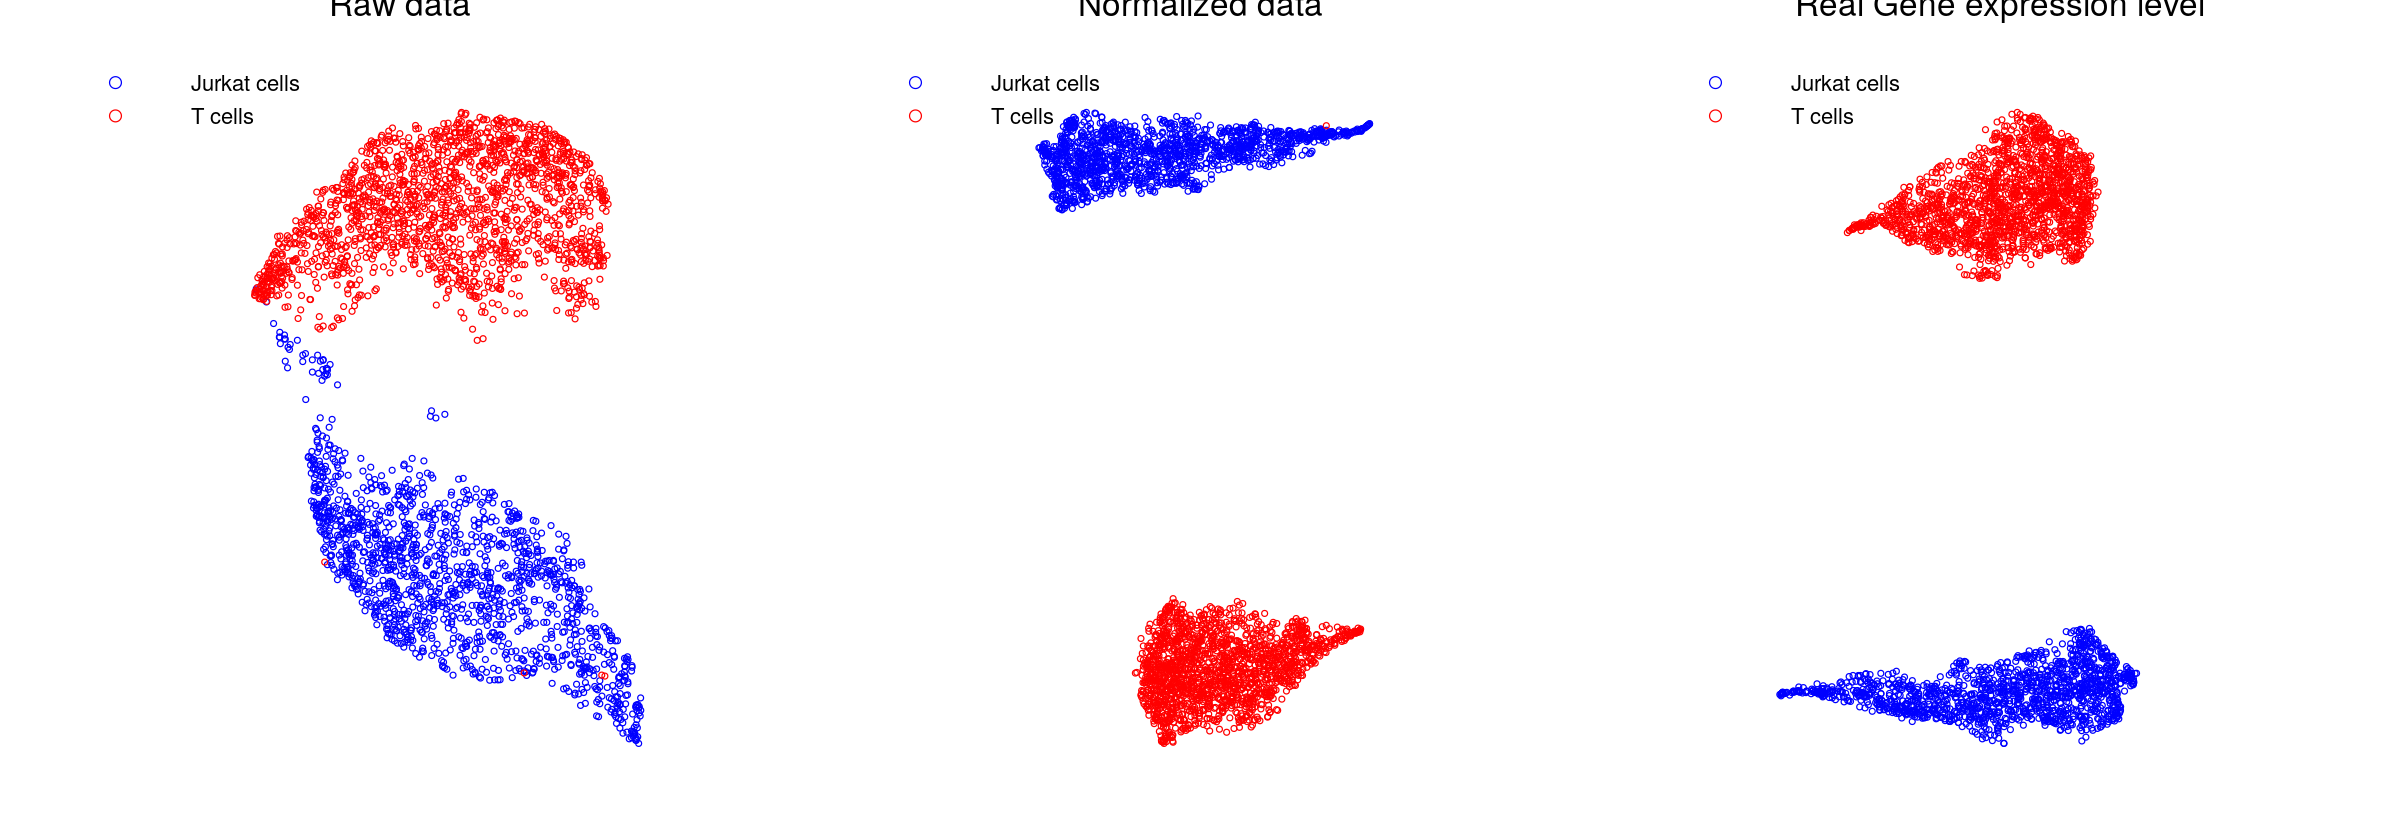

In [23]:
#Create 3 scatterplots for each dataset
par(mfrow=c(1,3))
options(repr.plot.width=20, repr.plot.height=7)
labelcell <- c( rep("Jurkat cells", 1440) , rep("T cells", 1718))
UMAP_plot(umap_count, labelcell, main = "Raw data")
UMAP_plot(umap_normalization, labelcell, main = "Normalized data")
UMAP_plot(umap_expression, labelcell, main = "Real Gene expression level")


Find differential expressed genes

.

In [25]:
#get the first 50 genes to see the different gene expression between Jurkat and T-cells
Jurkat <- c(0:1440)
T_cells <- c(1441:3158)
genelabel <- rownames(expression)
genelabel <- genelabel[1:20]

In [18]:
expression <- results_Zheng$gene_matrix
count <- results_Zheng$count_matrix              
normalization <- scran_normalization(count)


In [26]:
#This for loop shows the difference between gene expression of Jurkat and t cells
#dev.off()
value_DE_genes <- c()
for(label in genelabel){
    value<- t.test(expression[label, Jurkat],expression[label, T_cells] )
    value_DE_genes <- c(value_DE_genes, value$p.value)
   
}
names(value_DE_genes) <- genelabel
adjusted <- p.adjust(value_DE_genes, method = "BH")

sorted <- sort(adjusted)
DEgenelabel <- names(sorted[-(1:14)])

DEgenelabel


[1] "RP11-54O7.17"  "FAM41C"        "LINC00115"     "RP11-206L10.9"
[5] "C1orf170"      "RP11-54O7.1"

# Visualize differential expressed genes

.


In [29]:
#plotting the box plot to visualize different expressed genes
#op <- par(mfrow=c(1,2))
#options(repr.plot.width=10, repr.plot.height=2)
#par(mfrow=c(10,2))
for(label in DEgenelabel){
    #op <- par(mfrow=c(1,2))
    
    options(repr.plot.width=10, repr.plot.height=5)
    png(paste0("boxplot_", label, ".png"))
    boxplot(expression[label, Jurkat], expression[label, T_cells], main = paste0(label, "\n Gene expression level"), col = "red", 
          names = c("Jurkat", "T cells"), cex.axis=2, cex.main = 2)
   dev.off()
    
   png(paste0("UMAP_", label, ".png")) 
   UMAP_plot(umap_expression, labelcell, main = "Real Gene expression level", pch = 19 , alpha_jurkat =  ((mean(expression[label, Jurkat])) / (mean(expression[label, T_cells])))  , alpha_t_cells =  ((mean(expression[label, T_cells])) / mean(expression[label, Jurkat])) )
   dev.off()
   
}
